In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(8,8))
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0], cmap=plt.cm.Spectral)
    plt.show()


def load_flower_dataset(seed):
    
    np.random.seed(seed)
    
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [2]:
def sigmoid(z):
    """
    Sigmoid function
    """
    return 1/(1+np.exp(-z))

In [3]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

In [4]:
def initialize_weights(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    weights -- python dictionary containing your weights:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
   
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
  
    weights = {"W1": W1,
               "b1": b1,
               "W2": W2,
               "b2": b2}
    
    return weights

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)}$$

In [5]:
def loss_function(A2, Y):
    """
    Computes the cross-entropy cost given in equation
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost given by the upper equation
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost 
    cost = (-1/m) * (np.dot(np.log(A2), Y.T) + np.dot(np.log(1 - A2), (1 - Y).T))
    cost = float(np.squeeze(cost))  
                                    
    
    return cost

In [6]:
def predict(weights, X):
    """
    Using the learned weights, predicts a class for each example in X
    
    Arguments:
    weights -- python dictionary containing your weights 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, prev_activations = forward_propagation(X, weights)
    predictions = np.where(A2 > 0.5, 1, 0)
    
    return predictions

In [7]:
def update_weights(weights, gradients, learning_rate = 0.1):
    """
    Updates weights using the gradient descent update rule given above
    
    Arguments:
    weights -- python dictionary containing your weights 
    gradients -- python dictionary containing your gradients 
    
    Returns:
    weights -- python dictionary containing your updated weights 
    """
    # Retrieve each weights from the dictionary "weights"   
    W1 = weights["W1"]
    b1 = weights["b1"]
    W2 = weights["W2"]
    b2 = weights["b2"]
   
    # Retrieve each gradient from the dictionary "gradients"    
    dW1 = gradients["dW1"]
    db1 = gradients["db1"]
    dW2 = gradients["dW2"]
    db2 = gradients["db2"]
 
    # Update rule for each weights: the length of the steps is dictated by the learning_rate parameter
    W1 = W1 - (learning_rate * dW1)
    b1 = b1 - (learning_rate * db1)
    W2 = W2 - (learning_rate * dW2)
    b2 = b2 - (learning_rate * db2)
   
    
    weights = {"W1": W1,
               "b1": b1,
               "W2": W2,
               "b2": b2}
    
    return weights

In [8]:
def forward_propagation(X, weights):
    """
    Argument:
    X -- input data of size (n_x, m)
    weights -- python dictionary containing your weights (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    prev_activations -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each weights from the dictionary "weights"
    W1 = weights["W1"]
    b1 = weights["b1"]
    W2 = weights["W2"]
    b2 = weights["b2"]
     
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
   
    
    prev_activations = {"Z1": Z1,
                        "A1": A1,
                        "Z2": Z2,
                        "A2": A2}
    
    return A2, prev_activations

In [9]:
def backward_propagation(weights, prev_activations, X, Y):
    """
    Arguments:
    weights -- python dictionary containing our weights 
    prev_activations -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    gradients -- python dictionary containing your gradients with respect to different weights
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "weights".
    W1 = weights["W1"]
    W2 = weights["W2"]
  
        
    # Retrieve also A1 and A2 from dictionary "prev_activations".
    A1 = prev_activations["A1"]
    A2 = prev_activations["A2"]
   
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m)*np.dot(dZ2, A1.T)
    db2 = (1/m)*np.sum(dZ2, axis=1, keepdims=True) # keepdims need to ensure to output a (n x 1) vector
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m)*np.dot(dZ1, X.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)
  
    
    gradients = {"dW1": dW1,
                 "db1": db1,
                 "dW2": dW2,
                 "db2": db2}
    
    return gradients

In [10]:
def NeuralNetwork(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    weights -- weights learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize weights
    weights = initialize_weights(X.shape[0], n_h, Y.shape[0])
  
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
                
        # Forward propagation. Inputs: "X, weights". Outputs: "A2, prev_activations".
        A2, prev_activations = forward_propagation(X, weights)
        
        # Cost function. Inputs: "A2, Y, weights". Outputs: "cost".
        cost = loss_function(A2, Y)
 
        # Backpropagation. Inputs: "weights, prev_activations, X, Y". Outputs: "gradients".
        gradients = backward_propagation(weights, prev_activations, X, Y)
 
        # Gradient descent weights update. Inputs: "weights, gradients". Outputs: "weights".
        weights = update_weights(weights, gradients)
            
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return weights

Cost after iteration 0: 0.693148
Cost after iteration 1000: 0.647754
Cost after iteration 2000: 0.643359
Cost after iteration 3000: 0.641476
Cost after iteration 4000: 0.640310


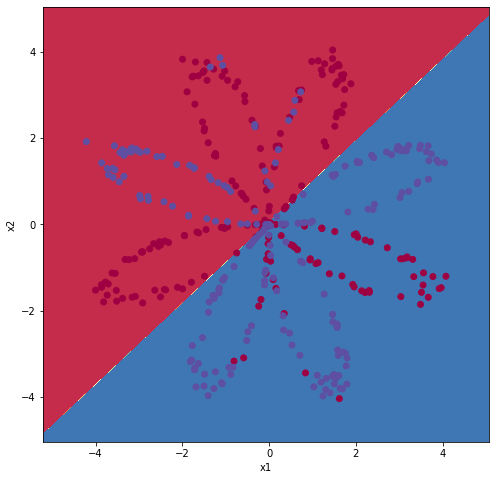

Accuracy for 1 hidden units: 67.0 %

Cost after iteration 0: 0.693116
Cost after iteration 1000: 0.604311
Cost after iteration 2000: 0.595697
Cost after iteration 3000: 0.591913
Cost after iteration 4000: 0.589561


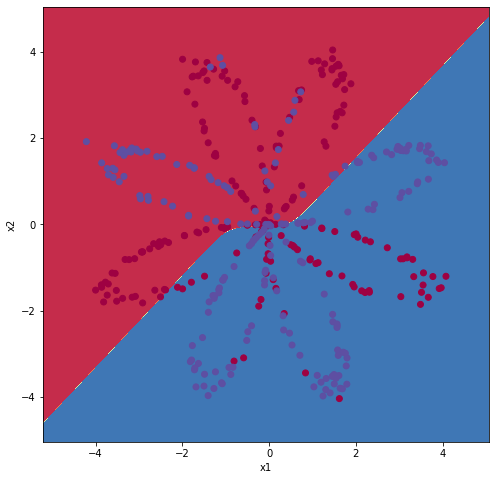

Accuracy for 2 hidden units: 64.75 %

Cost after iteration 0: 0.693252
Cost after iteration 1000: 0.445321
Cost after iteration 2000: 0.336054
Cost after iteration 3000: 0.317151
Cost after iteration 4000: 0.307778


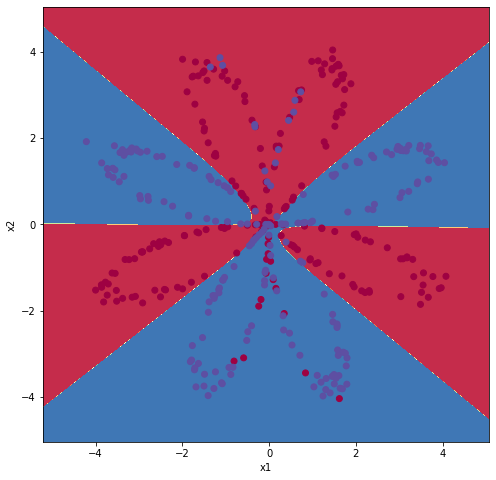

Accuracy for 5 hidden units: 88.5 %

Cost after iteration 0: 0.693224
Cost after iteration 1000: 0.630715
Cost after iteration 2000: 0.349228
Cost after iteration 3000: 0.320041
Cost after iteration 4000: 0.307892


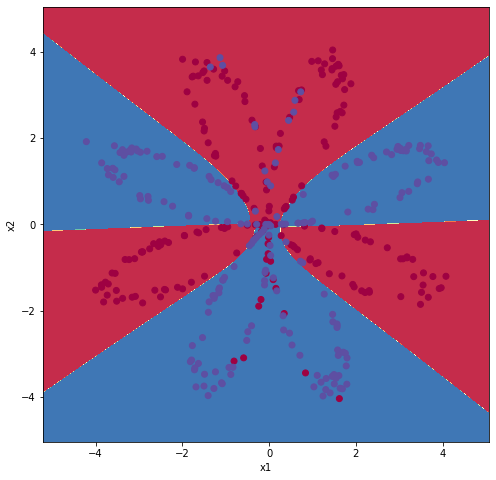

Accuracy for 50 hidden units: 88.75 %



In [11]:
# run model
X, Y = load_flower_dataset(1)
n_h = 4
hidden_layer_sizes = [1, 2, 5, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    weights = NeuralNetwork(X, Y, n_h, num_iterations = 5000, print_cost = True)
    plot_decision_boundary(lambda x: predict(weights, x.T), X, Y)
    predictions = predict(weights, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %\n".format(n_h, accuracy))